In [1]:
import pandas as pd
import numpy as np

from skimage.util.shape import view_as_blocks
from skimage.io import imread

from scipy.misc import imresize
import scipy.stats as stats

from multiprocessing import Pool, Process, Array
import multiprocessing as mp

# Inicialização de alguma variáveis

In [2]:
paths = pd.read_csv('../../IC2017_DATA/valid_images.csv')
n_images = len(paths)

names_VI = ["ExG", "ExGR", "CIVE", "VEG", "WI", "NGRDI"]

path_imgs = paths['pic'].values.copy()
path_gts = paths['gt'].values.copy()


In [3]:
resizing_factors = [8, 16, 32, 64, 128]
functions = [np.mean, np.max, np. min, np.std]
nr = len(resizing_factors)
nf = len(functions)

# Laço de criação das Features

In [4]:
"""
Ground Truth (GT) is generated here.
"""

GT = np.zeros((n_images*512*512, ), dtype = "uint8")
for i in range(n_images):
    gt = imread('../' + path_gts[i], as_gray=True)
    _max = np.max(gt)
    #print(i, _max)
    _max = _max if _max != 0 else 1
    #print(i, _max)
    gt = gt // _max
    GT[i*512*512: (i+1)*512*512] = gt.reshape(512*512)

In [5]:
"""
These variables are shared arrays to parallelize the feature creation
"""

shared = Array("d", (n_images * (512 * 512) * (1 + nr * nf)), lock=False)

In [6]:
npshared = np.frombuffer(shared).reshape(n_images * (512 * 512), (1 + nr * nf))
data = pd.DataFrame(npshared)
data.tail()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
15466491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15466492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15466493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15466494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15466495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
"""
This function is requied to use the shared variables as global variables in the shared enviroment.
"""

def _init(init_args):
    global shared
#     shared = init_args[0]

In [11]:
def worker(p):
    
    out = np.frombuffer(shared).reshape(n_images * (512 * 512), (1 + nr * nf))
    offset = 512 * 512

    print(p, end = ' ')
    pic = imread('../' + path_imgs[p], False)

    B, G, R = [np.float32(pic[:, :, c]) for c in range(3)]
    r = R / (R + G + B)
    g = G / (R + G + B)
    b = B / (R + G + B)

    divisor = G + R
    x = np.divide((G - R), divisor, out=np.zeros_like(divisor), where=divisor!=0) # NGRDI

    for i, r in enumerate(resizing_factors):
        s = 512 // r
        # print(x.shape, s)
        x_block = view_as_blocks(x, (s, s))
        for j, f in enumerate(functions):
            # print(i * nf + j, r, f)
            x_stat = f(x_block, axis = (2, 3))
            # x_rsz = imresize(x_stat, (512, 512))
            x_rsz = np.repeat(x_stat, s, axis = 0)
            x_rsz = np.repeat(x_rsz, s, axis = 1)
            out[p * offset : (p + 1) * offset , i * nf + j] = x_rsz.ravel()
    
    # insert last columns: original filter
    out[(p) * offset : (p + 1) * offset, nr * nf] = x.ravel()
        
    print("done")
    return p

In [12]:
"""
Define pool of processes
"""
pool = Pool(processes=4, initializer=_init, initargs=([shared],))

4 done
8 done
12 done
0 done
5 done
13 done
6 done
1 done
9 done
2 done
14 done
7 done
10 done
3 done
15 done
16 done
20 done
11 done
24 done
21 done
28 done
17 done
22 done
25 done
18 done
23 done
29 done
26 done
19 done
32 done
30 done
27 done
36 done
31 done
40 done
44 done
33 done
37 done
45 done
34 done
41 done
38 done
46 done
35 done
39 done
42 done
47 done
48 done
56 done
52 done
57 done
49 done
43 done
53 done
58 done
50 done
54 done
51 done
55 done


In [13]:
# %%time
"""
Execute pool of processes
"""
pool.map(worker, range(n_images))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58]

In [14]:
tuples = [(r, f) for r in resizing_factors for f in ['mean', 'max', 'min', 'std']]  + [(512, 'ori')]
mi = pd.MultiIndex.from_tuples(tuples)

In [15]:
npshared = np.frombuffer(shared).reshape(n_images * (512 * 512), (1 + nr * nf))
data = pd.DataFrame(npshared, columns=mi)
data.tail()

8                                       16             \
              mean       max       min       std      mean       max   
15466491  0.175106  0.519481  0.027972  0.074653  0.111336  0.252747   
15466492  0.175106  0.519481  0.027972  0.074653  0.111336  0.252747   
15466493  0.175106  0.519481  0.027972  0.074653  0.111336  0.252747   
15466494  0.175106  0.519481  0.027972  0.074653  0.111336  0.252747   
15466495  0.175106  0.519481  0.027972  0.074653  0.111336  0.252747   

                                   32             ...                 64   \
               min       std      mean       max  ...       std      mean   
15466491  0.063613  0.024152  0.104668  0.146667  ...  0.018213  0.111664   
15466492  0.063613  0.024152  0.104668  0.146667  ...  0.018213  0.111664   
15466493  0.063613  0.024152  0.104668  0.146667  ...  0.018213  0.111664   
15466494  0.063613  0.024152  0.104668  0.146667  ...  0.018213  0.111664   
15466495  0.063613  0.024152  0.104668  0.146667  ...  0.018213  0.111664   

                                             128                      \
               max       min       std      mean       max       min   
15466491  0.140127  0.089855  0.014465  0.110900  0.127596  0.090426   
15466492  0.140127  0.089855  0.014465  0.098208  0.106628  0.089855   
15466493  0.140127  0.089855  0.014465  0.098208  0.106628  0.089855   
15466494  0.140127  0.089855  0.014465  0.098208  0.106628  0.089855   
15466495  0.140127  0.089855  0.014465  0.098208  0.106628  0.089855   

                         512  
               std       ori  
15466491  0.013275  0.127596  
15466492  0.004800  0.096970  
15466493  0.004800  0.099379  
15466494  0.004800  0.095975  
15466495  0.004800  0.094118  

[5 rows x 21 columns]

In [16]:
IMG = np.zeros(n_images*512*512, dtype="uint8")
for i in range(len(paths)):
    IMG[(i) * 512 * 512 : (i + 1) * 512 * 512] = paths.iloc[i]['num']

In [17]:
data["GT"] = GT
data["IMG"] = IMG

In [18]:
data['solo'] = 1
data.loc[data.IMG <= 17, 'solo'] = 0
data.loc[data.IMG >= 40, 'solo'] = 2

In [19]:
data.to_csv("../../IC2017_DATA/FancyApproach_dataset-Repeat.csv", index=False)

# Análises

# Análise das VIs (curva ROC)

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

8	mean	AUC = 0.9341
16	mean	AUC = 0.9408
32	mean	AUC = 0.9386
64	mean	AUC = 0.9216
128	mean	AUC = 0.8966


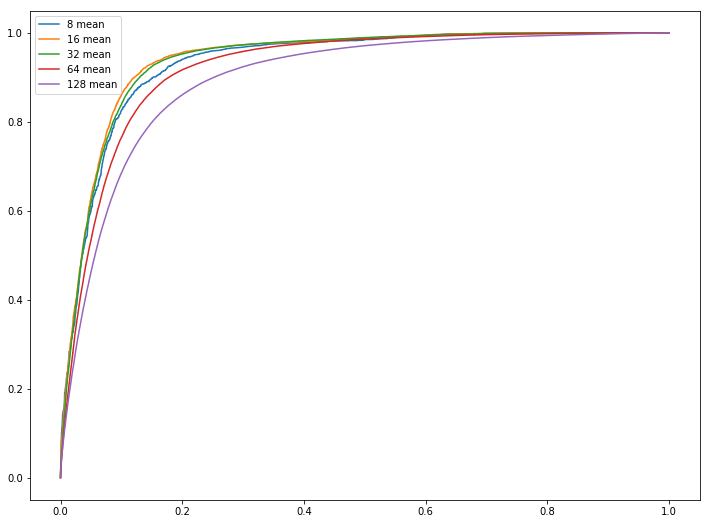


8	max	AUC = 0.9122
16	max	AUC = 0.9361
32	max	AUC = 0.9417
64	max	AUC = 0.9341
128	max	AUC = 0.9151


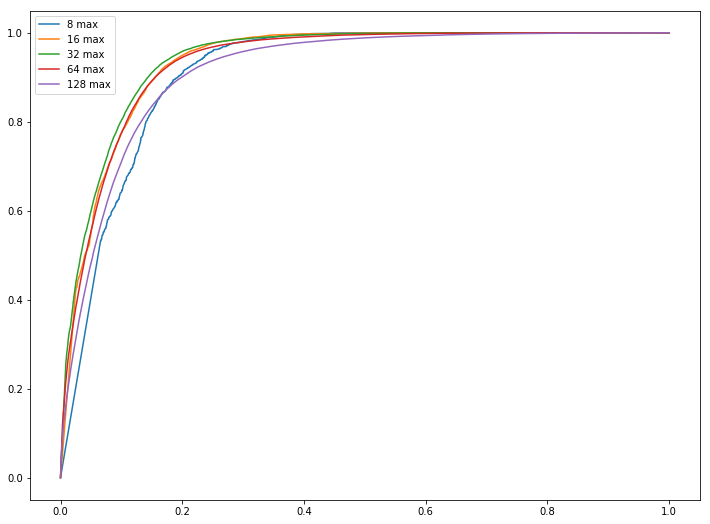


8	min	AUC = 0.5207
16	min	AUC = 0.6123
32	min	AUC = 0.7111
64	min	AUC = 0.7841
128	min	AUC = 0.8309


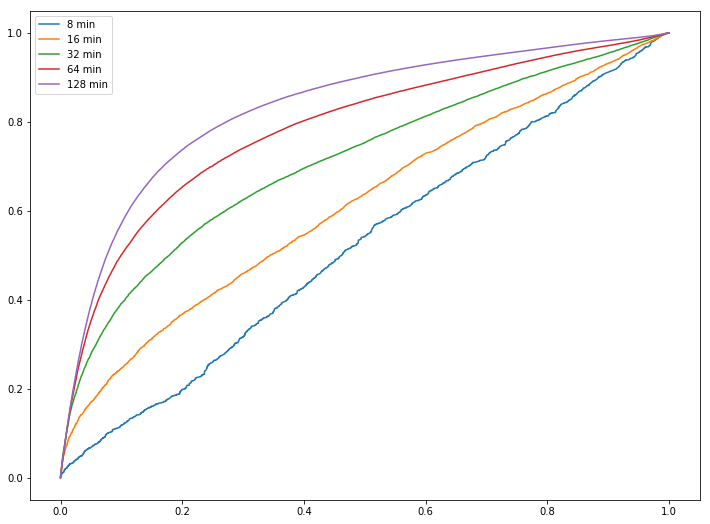


8	std	AUC = 0.8801
16	std	AUC = 0.8957
32	std	AUC = 0.8960
64	std	AUC = 0.8810
128	std	AUC = 0.8544


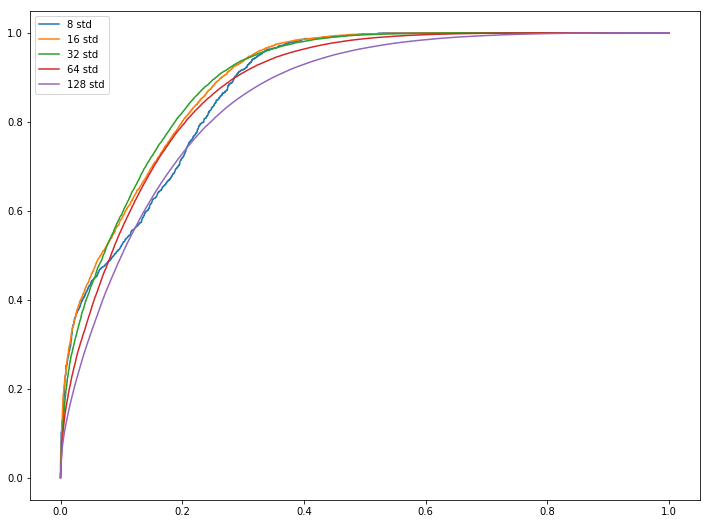

In [21]:
for f in ['mean', 'max', 'min', 'std']:
    plt.figure(figsize=(12,9))
    for r in resizing_factors:
        fpr, tpr, th = roc_curve(GT, data[r][f])
        plt.plot(fpr,tpr, label = f'{r} {f}')
        score = auc(fpr, tpr)
        print("%d\t%s\tAUC = %.4f" % (r, f, score))
        
    plt.legend()    
    plt.show()
    print()



512	ori	AUC = 0.8718


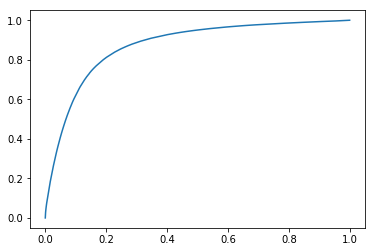

In [23]:
r, f = 512, 'ori'
fpr, tpr, th = roc_curve(GT, data[r][f])
plt.plot(fpr,tpr, label = f'{r} {f}')
score = auc(fpr, tpr)
print("%d\t%s\tAUC = %.4f" % (r, f, score))